In [1]:
import numpy as np
import pandas as pd
import h3
import folium
import json
from folium import plugins
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pickle
import branca.colormap as cmp

In [2]:
#create dataset
data_with_hexagons = pd.read_csv("10_percent_consump.csv",parse_dates=["Trip End Timestamp"]).drop("Unnamed: 0", axis=1)
data_with_hexagons["hex_id"] = data_with_hexagons.apply(lambda x:h3.geo_to_h3(
        lat=x["Dropoff Centroid Latitude"],
        lng=x["Dropoff Centroid Longitude"],
        resolution=7
    ),axis=1)
data_with_hexagons.drop(axis=1,labels=["Pickup Centroid Latitude","Pickup Centroid Longitude","Dropoff Centroid Latitude","Dropoff Centroid Longitude"],inplace=True)
data_with_hexagons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10356323 entries, 0 to 10356322
Data columns (total 11 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Trip Start Timestamp      object        
 1   Trip End Timestamp        datetime64[ns]
 2   Trip Seconds              float64       
 3   Trip Miles                float64       
 4   max_temp                  float64       
 5   min_temp                  float64       
 6   precip                    float64       
 7   Trip min                  int64         
 8   consumption_city_kWh      float64       
 9   consumption_combined_kWh  float64       
 10  hex_id                    object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 869.1+ MB


### Custom prediction based on city total prediction

In [3]:
#get a list of trips grouped by destination h3 cell, resampled by hour
list_by_hex_id_pred = pd.Series(dtype=object)
def group_processor(group):
    min_trips = 1
    if(len(group.index) >= min_trips):
        list_by_hex_id_pred[group.iloc[0]["hex_id"]] = group

data_with_hexagons.groupby(by="hex_id").apply(group_processor)

for index, df in list_by_hex_id_pred.iteritems():
    df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"])
    hourly_data = df[[
        "Trip Start Timestamp",
        "Trip Seconds",
        "max_temp",
        "min_temp",
        "precip",
        "Trip min",
        "consumption_city_kWh",
        "consumption_combined_kWh"
        ]].resample("H",on="Trip Start Timestamp").agg({
            "Trip Seconds":"count",
            "max_temp":"mean",
            "min_temp":"mean",
            "precip":"mean",
            "Trip min":"sum",
            "consumption_city_kWh":"sum",
            "consumption_combined_kWh":"sum"
            })
    hourly_data["hour"] = hourly_data.index.to_series().apply(lambda x:x.hour)
    #add weekend/day feature
    hourly_data["weekday"] = hourly_data.index.to_series().apply(lambda x:0 if x.dayofweek in [5,6] else 1)
    #add day of week feature
    hourly_data["day_of_week"] = hourly_data.index.to_series().apply(lambda x:x.dayofweek)
    hourly_data["hex_id"] = hourly_data.index.to_series().apply(lambda x:index)
    hourly_data.rename(columns={"Trip Seconds":"trip_total","Trip min":"Aggretaged total Minutes Usage"},inplace=True)
    hourly_data.dropna(inplace=True)
    list_by_hex_id_pred[index] = hourly_data
#list is a pd.Series with h3 ids as index with hourly dataframes as value
print("Cells", len(list_by_hex_id_pred))
list_by_hex_id_pred.iloc[0].head(3)

Cells 129


,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,weekday,day_of_week,hex_id
Trip Start Timestamp,,,,,,,,,,,
2019-01-01 09:00:00,1,0.0,0.0,0.0,15,2.83709,3.04313,9,1,1,872664191ffffff
2019-01-01 16:00:00,1,-2.2,-2.2,0.0,37,4.85957,5.21249,16,1,1,872664191ffffff
2019-01-01 21:00:00,1,-2.8,-2.8,1.0,13,1.85394,1.98858,21,1,1,872664191ffffff


In [4]:
#create train and test set for each cell
test_sets = pd.Series(dtype=object)
train_sets = pd.Series(dtype=object)
for index, cel_df in list_by_hex_id_pred.iteritems():
    #cannot train/test split with less than 4 entries
    if len(cel_df.index) < 4 : continue
    featured_data = cel_df[[
        "max_temp","min_temp","precip","hour","weekday","day_of_week"
    ]]
    X_train, X_test, y_train, y_test = train_test_split(cel_df, cel_df["consumption_city_kWh"],test_size=0.3, random_state=1)
    train_sets[index] = {"X":X_train,"y":y_train}
    test_sets[index] = {"X":X_test,"y":y_test}
train_sets.iloc[0]["X"].head(3)


,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,weekday,day_of_week,hex_id
Trip Start Timestamp,,,,,,,,,,,
2019-05-04 10:00:00,1,4.4,4.4,0.0,18,1.46068,1.56676,10,0,5,872664191ffffff
2019-10-04 15:00:00,1,12.2,11.7,0.0,4,0.30899,0.33143,15,1,4,872664191ffffff
2019-10-17 17:00:00,1,10.6,10.6,0.0,18,1.68540,1.80780,17,1,3,872664191ffffff


In [5]:
#get total consumption per hour full year
total_consumption = pd.Series(dtype=float)
for index, obj in train_sets.iteritems():
    consumption = obj["y"].groupby(lambda x: x.hour).sum()
    if len(total_consumption.index) == 0:
        total_consumption = consumption
    else:
        total_consumption = pd.concat([consumption, total_consumption]).groupby(by=lambda x:x).sum()
#get total consumption ratio per cell per hour of full year
cell_consumption_ratios = pd.DataFrame()
for index, obj in train_sets.iteritems():
    consumption = obj["y"].groupby(lambda x: x.hour).sum()
    helper_dict = dict()
    for hour, hour_consump in consumption.iteritems():
        helper_dict[hour] = hour_consump/total_consumption[hour]# get ratio of consumed kWh
    if len(cell_consumption_ratios.index) == 0:
        cell_consumption_ratios = pd.DataFrame(index = [index], data=helper_dict)
    else:
        cell_consumption_ratios = pd.concat([cell_consumption_ratios, pd.DataFrame(index = [index], data=helper_dict)])

#if NaN there are not trips aka => 0 kWh
cell_consumption_ratios.fillna(0, inplace=True)
    
cell_consumption_ratios

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
872664191ffffff,0.000493,0.000532,0.000726,0.000833,0.000589,0.001588,0.000465,0.000399,0.000279,2.928220e-04,...,0.000486,0.000547,0.000400,0.000709,0.000397,0.000397,0.000446,0.000475,0.000488,0.000403
872664193ffffff,0.000000,0.000000,0.000104,0.000000,0.000000,0.000002,0.000000,0.000030,0.000020,9.614512e-07,...,0.000000,0.000000,0.000010,0.000029,0.000006,0.000000,0.000000,0.000000,0.000004,0.000000
872664194ffffff,0.000020,0.000029,0.000067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.932426e-05,...,0.000000,0.000029,0.000047,0.000016,0.000020,0.000025,0.000015,0.000000,0.000009,0.000000
872664196ffffff,0.001845,0.002100,0.002163,0.002420,0.002879,0.004309,0.001630,0.001576,0.001347,1.278910e-03,...,0.001522,0.001196,0.001585,0.002076,0.001075,0.001068,0.001213,0.001259,0.001452,0.001632
8726641b2ffffff,0.001354,0.001564,0.001485,0.001526,0.000647,0.000493,0.000435,0.000430,0.000460,3.593424e-04,...,0.000619,0.000848,0.000882,0.000742,0.000693,0.000768,0.000800,0.000620,0.000862,0.001093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87275934effffff,0.001537,0.002225,0.012939,0.086290,0.223482,0.319134,0.256539,0.140767,0.096688,1.069876e-01,...,0.136451,0.128685,0.107674,0.075445,0.054069,0.033289,0.018054,0.008921,0.005497,0.003256
872759369ffffff,0.004060,0.005338,0.007127,0.005667,0.004420,0.004203,0.003343,0.002934,0.002466,2.292039e-03,...,0.002173,0.002315,0.001908,0.001984,0.002103,0.002246,0.002545,0.002964,0.003174,0.004003
87275936bffffff,0.001539,0.000956,0.001174,0.001275,0.000343,0.000673,0.001632,0.002176,0.002085,2.091937e-03,...,0.001172,0.001093,0.001116,0.001022,0.001029,0.001266,0.002091,0.002383,0.002339,0.002147
87275936cffffff,0.000156,0.000207,0.000078,0.000013,0.000005,0.000000,0.000000,0.000018,0.000007,1.153741e-05,...,0.000010,0.000004,0.000013,0.000002,0.000025,0.000004,0.000008,0.000034,0.000058,0.000072


In [6]:
cell_consumption_ratios.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,...,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752,0.007752
std,0.014541,0.013932,0.011807,0.014579,0.026220,0.031686,0.027896,0.023849,0.025359,0.024156,...,0.020498,0.019670,0.017967,0.017253,0.016972,0.017129,0.016865,0.016802,0.015927,0.015647
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000000
25%,0.000621,0.000528,0.000624,0.000283,0.000130,0.000127,0.000204,0.000616,0.000535,0.000396,...,0.000619,0.000722,0.000749,0.000740,0.000678,0.000607,0.000617,0.000620,0.000692,0.000727
50%,0.003073,0.003430,0.003608,0.002709,0.001525,0.001358,0.001630,0.002103,0.001969,0.002046,...,0.002466,0.002603,0.002540,0.002451,0.002238,0.002307,0.002545,0.002740,0.002873,0.003096
75%,0.007912,0.008229,0.009991,0.009866,0.004775,0.003745,0.003763,0.005139,0.004875,0.004628,...,0.006012,0.006000,0.006754,0.006651,0.006399,0.006374,0.006415,0.006294,0.006503,0.007123
max,0.122044,0.112653,0.082070,0.106496,0.223482,0.319134,0.256539,0.170027,0.193445,0.194097,...,0.160206,0.157308,0.144704,0.146225,0.147705,0.151739,0.149791,0.149216,0.139124,0.139074


In [7]:
#load city overall model and create custom prediction function
model_total_city = pickle.load(open("model_total_city.sav", 'rb'))
model_total_city_scaler = pickle.load(open("model_total_city_scaler.sav", 'rb'))
"""
param_X : ["max_temp","min_temp","precip","hour","weekday","day_of_week"]
"""
def custom_prediction(X, cell_id):
    trans_X = model_total_city_scaler.transform(X)
    total_consump = model_total_city.predict(trans_X)
    ratios = pd.Series(dtype=float)
    for index, row in X.iterrows():
        ratios[index] = cell_consumption_ratios.at[cell_id,row["hour"]]
    return total_consump*ratios
    


In [8]:
# run custom prediction for each cell
performance_df = pd.DataFrame({"MSE":[],"MAE":[],"r2":[]})
for index, value in test_sets.iteritems():
    features = value["X"][[
        "max_temp",
        "min_temp",
        "precip",
        "hour",
        "weekday",
        "day_of_week"
    ]]
    predicted_values = custom_prediction(features, index)
    mse = mean_squared_error(value["y"],predicted_values)
    mae = mean_absolute_error(value["y"],predicted_values)
    r2 = r2_score(value["y"],predicted_values)
    temp_df = pd.DataFrame(data={"MSE":mse,"MAE":mae,"r2":r2}, index = [index])
    performance_df = pd.concat([performance_df, temp_df])
performance_df.head(3)

,MSE,MAE,r2
872664191ffffff,15.876612,2.775792,-0.770605
872664193ffffff,15.442343,3.375784,-2.818517
872664194ffffff,15.751586,3.707615,-6.823345


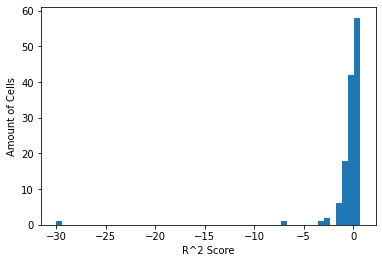

In [9]:
#assess effectiveness of models
plt.hist(performance_df["r2"], bins=50)
plt.xlabel("R^2 Score")
plt.ylabel("Amount of Cells")
plt.show()

In [12]:
#show predictions on map (only with positive r2 score)
# OpenStreetMap, Stamen Toner
cust_pred_map = folium.Map(location=(41.873222041337044, -87.62596070777431), tiles='OpenStreetMap', zoom_start=11, control_scale=True, max_zoom=20)
#create geo_json
cust_geo = pd.Series(dtype=object)
for index, row in performance_df.iterrows():
    if row["r2"] < 0 : continue
    hex_json = h3.h3_to_geo_boundary(index, geo_json=True)
    #if hexagon is already drawn
    cust_geo.loc[index] = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [json.loads(json.dumps(hex_json))]
            },
            "properties":{
                "score":row["r2"]
            }
        }
max_pred = performance_df["r2"].max()
min_pred = 0
print("Max Score", max_pred)
#paint on map
color_map = cmp.LinearColormap(
 ['blue', "yellow",'red'],
 vmin=0, vmax=0.8,
 caption='Score'    #Caption for Color scale or Legend
)
#paint on map
def pred_style_function(x):
    #r, g ,b = rgb(0, np.log(max_value), np.log(x["properties"]["accu_city_kWh"]))
    return {
        "color":color_map(x["properties"]["score"]),
        "weight":1,
        "opacity":1,
        "fillOpacity": .6
    }
    

for index, geo_json in cust_geo.iteritems():
    layer = folium.GeoJson(geo_json,style_function=pred_style_function,tooltip=f'Score: {geo_json["properties"]["score"]} - ID: {index}')
    layer.add_to(cust_pred_map)

color_map.add_to(cust_pred_map)
cust_pred_map

Max Score 0.7281618871367457
